In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
import json
import re

## loading data

### finding invalid lines

In [220]:
df = pd.read_json('./plant_data.json', lines=True)

In [221]:
counter = 0
for line in open('./plant_data.json'):
    try:
        counter += 1
        json.loads(line)
    except Exception as ex:
        print(ex)
        print("failed on %s \n" % counter)

## drop almost empty cols and rows

In [222]:
df.describe(include='all')

,name,img,plant habit,life cycle,flowers,propagation: other methods,sun requirements,leaves,uses,wildlife attractant,...,physiological resistance,flesh color,comments by nj ag exp st.,days to maturity,division,special classifications,spring bloom season,year registered,notes,pollen parent
count,150966,33927,101124,82821,77675,68339,74700,54645,65595,49102,...,37,544,266,347,3309,3166,3148,2365,32,1
unique,150351,30502,24,7,323,359,27,1436,360,55,...,10,21,241,91,15,14,9,191,32,1
top,Nymphaea-micrantha,/i/iucn/1535.png,herb/forb,perennial,showy,cuttings: stem\ncuttings: tip\ncuttings: cane,full sun,evergreen,suitable as annual,bees\nbutterflies\nhummingbirds,...,cracking,red,sweet flavor,80,div. 3: triumph,single-flowered,mid-season,2008,"am-kavb 1947, fa-kavb 1950, fcfa-kavb 1951, fc...",violetto nive
freq,4,459,48022,76147,56987,14046,26509,27585,16944,20043,...,18,324,5,41,1175,1897,1451,86,1,1
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [223]:
df_cleaned = df.drop_duplicates(['name']).dropna(subset=['uses']).dropna(axis=0,thresh=10).dropna(axis=1,thresh=10000).drop(columns=['propagation: seeds'])

## fix values

### using dictionaries
### using regex from text length to actual size in inches
### merging "other" values

In [ ]:
bloom_dict = {
    'under 1"': 0,
        '1"-2"': 1,
        '2"-3"': 2,
        '3"-4"': 3,
        '4"-5"': 4,
        '5"-6"': 5,
        '6"-12"': 6,
}
cold_hardiness_dict = {
    'zone 2 -45.6 °c (-50 °f) to -42.8 °c (-45°f)': 0,
    'zone 3 -40 °c (-40 °f) to -37.2 °c (-35)': 1,
    'zone 4a -34.4 °c (-30 °f) to -31.7 °c (-25 °f)': 2,
    'zone 4b -31.7 °c (-25 °f) to -28.9 °c (-20 °f)': 3,
    'zone 5a -28.9 °c (-20 °f) to -26.1 °c (-15 °f)': 4,
    'zone 5b -26.1 °c (-15 °f) to -23.3 °c (-10 °f)': 5,
    'zone 6a -23.3 °c (-10 °f) to -20.6 °c (-5 °f)': 6,
    'zone 6b -20.6 °c (-5 °f) to -17.8 °c (0 °f)': 7,
    'zone 7a -17.8 °c (0 °f) to -15 °c (5 °f)': 8,
    'zone 7b -15 °c (5 °f) to -12.2 °c (10 °f)': 9,
    'zone 8a -12.2 °c (10 °f) to -9.4 °c (15 °f)': 10,
    'zone 8b -9.4 °c (15 °f) to -6.7 °c (20 °f)': 11,
    'zone 9a -6.7 °c (20 °f) to -3.9 °c (25 °f)': 12,
    'zone 9b -3.9 °c (25 °f) to -1.1 °c (30 °f)': 13,
    'zone 10a -1.1 °c (30 °f) to +1.7 °c (35 °f)': 14,
    'zone 10b +1.7 °c (35 °f) to +4.4 °c (40 °f)': 15,
    'zone 11 +4.4 °c (40 °f) to +7.2 °c (50 °f)': 16
}

df_cleaned['bloom size'] = df_cleaned['bloom size'].map(lambda x: bloom_dict.get(x))
df_cleaned['minimum cold hardiness']= df_cleaned['minimum cold hardiness'].map(lambda x: cold_hardiness_dict.get(x))

In [129]:
df_not_red_other = df_cleaned.copy()
def replace_other(from_txt, string):
    if pd.notnull(string):
        to_return = re.sub(r'(%s.*)[\n]*' % from_txt, '%s\n' % from_txt.rstrip(':'), string).rstrip('\n')
        if 'late' in to_return:
            return re.sub(r'late\s(\w.*?)\s.*[\n]*', r'\1\n', to_return).rstrip('\n').strip()
        else:
            return to_return
    else:
        return string
        
def extract_sizes(txt):
    if type(txt) != str:
        return np.nan
    if 'year average' in txt:
        txt = txt.split('year average')[1]
    numbers = [int(s.replace('"','').replace('\'','')) for s in re.findall('\d+', txt)]
    if not len(numbers):
        if 'thirty feet' in txt:
            return 360
        return np.nan
    first_number = numbers[0]
    if 'inch' in txt or 'in.' in txt or 'imches' in txt:
        return first_number
    elif 'feet' in txt or 'ft' in txt or 'foot' in txt:
        return first_number * 12
    elif '"' in txt or '\'' in txt:
        return first_number
    elif 'cm' in txt:
        return first_number * 0.4
    else:
        return np.nan
    
# WIP - flower time + miscellaneous
        
df_not_red_other['fruit'] = df_not_red_other['fruit'].map(lambda x: replace_other('other:', x))
df_not_red_other['leaves'] = df_not_red_other['leaves'].map(lambda x: replace_other('other:', x))
df_not_red_other['flower color'] = df_not_red_other['flower color'].map(lambda x: replace_other('other:', x)).map(lambda x: replace_other('bi-color:', x)).map(lambda x: replace_other('multi-color:', x))
df_not_red_other['flower time'] = df_not_red_other['flower time'].map(lambda x: replace_other('other:', x))
# df_not_red_other['miscellaneous'] = df_not_red_other['miscellaneous'].map(lambda x: replace_other('plant breeders', x)).map(lambda x: replace_other('endangered:', x))
# df_not_red_other['plant spread'] = df_not_red_other['plant spread'].map(extract_sizes)
df_not_red_other['plant height'] = df_not_red_other['plant height'].map(extract_sizes)

## convert array values to bool features

### grouping similar columns

In [131]:
featured_df = df_not_red_other.copy()
for main_column in df_not_red_other.columns:
    if featured_df[main_column].nunique() < 500 and main_column not in ['bloom size', 'minimum cold hardiness', 'plant height', 'plant spread']:
        print(f'column splitted: {main_column}')
        dff = df_cleaned[main_column].str.get_dummies('\n').add_prefix(main_column+ '_').astype(bool)
        for col in dff.columns:
            if dff[col].value_counts()[True] < 100:
                dff = dff.drop(col,1)
        featured_df = pd.concat([featured_df.drop(main_column, 1), dff], axis=1)

plant habit
life cycle
flowers
propagation: other methods
sun requirements
leaves
uses
wildlife attractant
containers
water preferences
flower color
flower time
pollinators
resistances
fruit
edible parts


,name,img,plant height,bloom size,minimum cold hardiness,plant habit_cactus/succulent,plant habit_grass/grass-like,plant habit_herb/forb,plant habit_shrub,plant habit_tree,...,resistances_tolerates dry shade,fruit_dehiscent,fruit_edible to birds,fruit_other,fruit_pops open explosively when ripe,fruit_showy,edible parts_flowers,edible parts_fruit,edible parts_leaves,edible parts_seeds or nuts
1,Abelia-Zabelia-biflora,/pics/2019-07-25/DaylilySLP/2fccf8-300.jpg,NaN,NaN,NaN,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
2,Twinflower-Linnaea-borealis,/pics/2014-07-22/Prosedda/edef96-300.jpg,2.0,0.0,NaN,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,Glossy-Abelia-Zabelia-buddleioides,NaN,NaN,NaN,NaN,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,Chinese-Abelia-Abelia-chinensis,/pics/2019-09-13/dawiz1753/bef3ed-300.jpg,60.0,0.0,NaN,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,Glossy-Abelia-Zabelia-corymbosa,NaN,NaN,NaN,NaN,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150095,Yarrow-Achillea-W-B-Childs,NaN,NaN,NaN,NaN,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
150096,Yarrow-Achillea-millefolium-Walther-Funcke,/pics/2017-10-06/cliftoncat/409490-300.jpg,12.0,NaN,NaN,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
150097,Yarrow-Achillea-millefolium-Wesersandstein,/pics/2020-06-28/kniphofia/22072f-300.jpg,NaN,NaN,NaN,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
150196,Ornamental-Corn-Zea-mays-Blue-Miniature,/pics/2015-09-28/TBGDN/fbe0e7-300.jpg,36.0,NaN,NaN,False,True,False,False,False,...,False,False,True,True,False,True,False,True,False,False


In [132]:
grouped_df = featured_df.copy()
cols_to_merge = {
    'propagation: other methods_cuttings': 'propagation_cuttings',
    'propagation: other methods_other': 'propagation_other',
    'flowers_other': 'flowers_other',
    'fruit_other': 'fruit_other',
    'wildlife attractant_other beneficial insects': 'wildlife attractant  other',
    'containers_preferred depth': 'containers_preferred_depth_other'
}

for key, value in cols_to_merge.items():
    cutting_cols = list(filter(lambda x: key in x, grouped_df.columns))
    grouped_df[value] = grouped_df[cutting_cols].apply(
        lambda x: x.any(),
        axis=1
    )
    grouped_df = grouped_df.drop(columns=list(cutting_cols))

,name,img,plant height,bloom size,minimum cold hardiness,plant habit_cactus/succulent,plant habit_grass/grass-like,plant habit_herb/forb,plant habit_shrub,plant habit_tree,...,fruit_showy,edible parts_flowers,edible parts_fruit,edible parts_leaves,edible parts_seeds or nuts,propagation_cuttings,propagation_other,flowers_other,wildlife attractant other,containers_preferred_depth_other
1,Abelia-Zabelia-biflora,/pics/2019-07-25/DaylilySLP/2fccf8-300.jpg,NaN,NaN,NaN,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
2,Twinflower-Linnaea-borealis,/pics/2014-07-22/Prosedda/edef96-300.jpg,2.0,0.0,NaN,False,False,True,True,False,...,False,False,False,False,False,True,False,False,False,False
3,Glossy-Abelia-Zabelia-buddleioides,NaN,NaN,NaN,NaN,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,Chinese-Abelia-Abelia-chinensis,/pics/2019-09-13/dawiz1753/bef3ed-300.jpg,60.0,0.0,NaN,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
7,Glossy-Abelia-Zabelia-corymbosa,NaN,NaN,NaN,NaN,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150095,Yarrow-Achillea-W-B-Childs,NaN,NaN,NaN,NaN,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
150096,Yarrow-Achillea-millefolium-Walther-Funcke,/pics/2017-10-06/cliftoncat/409490-300.jpg,12.0,NaN,NaN,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
150097,Yarrow-Achillea-millefolium-Wesersandstein,/pics/2020-06-28/kniphofia/22072f-300.jpg,NaN,NaN,NaN,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,False
150196,Ornamental-Corn-Zea-mays-Blue-Miniature,/pics/2015-09-28/TBGDN/fbe0e7-300.jpg,36.0,NaN,NaN,False,True,False,False,False,...,True,False,True,False,False,False,False,False,False,False


In [224]:
drop_str = ['fruit', 'resistances', 'wildlife attractant', 'sun requirements', 'life cycle','minimum cold hardiness', 'containers', 'pollinators', 'underground structures', 'propagation', 'flowers', 'name', 'img']
drop_cols = filter(lambda x: any(string in x for string in drop_str), grouped_df.columns)
min_df = grouped_df.drop(columns=drop_cols)

121

## examing correlation

### minimizing number of feature correlation for view
### visualizing modified correlation matrix

In [134]:
grouped_df.corr().unstack().sort_values(ascending=False).drop_duplicates().head(50)

plant height                       plant height                                 1.000000
leaves_needled                     water preferences_wet                        0.916174
water preferences_dry mesic        water preferences_dry                        0.895301
pollinators_bumblebees             wildlife attractant  other                   0.873239
water preferences_wet mesic        water preferences_wet                        0.862094
leaves_needled                     pollinators_wind                             0.844198
pollinators_self                   containers_preferred_depth_other             0.806307
wildlife attractant  other         flowers_blooms on new wood                   0.796292
leaves_needled                     water preferences_wet mesic                  0.795915
plant habit_vine                   uses_vegetable                               0.793591
water preferences_wet              pollinators_wind                             0.786501
flower time_year roun

In [135]:
grouped_df.corr().unstack().sort_values().drop_duplicates().head(50)

uses_vegetable                               flowers_showy                                -0.763628
flowers_showy                                plant habit_vine                             -0.672244
plant habit_shrub                            plant habit_herb/forb                        -0.612198
flowers_showy                                minimum cold hardiness                       -0.554847
life cycle_perennial                         life cycle_annual                            -0.537019
flowers_showy                                edible parts_fruit                           -0.523920
containers_suitable in 3 gallon or larger    edible parts_fruit                           -0.514863
propagation_cuttings                         plant habit_herb/forb                        -0.507538
life cycle_perennial                         edible parts_fruit                           -0.502208
sun requirements_full sun to partial shade   uses_vegetable                               -0.489601


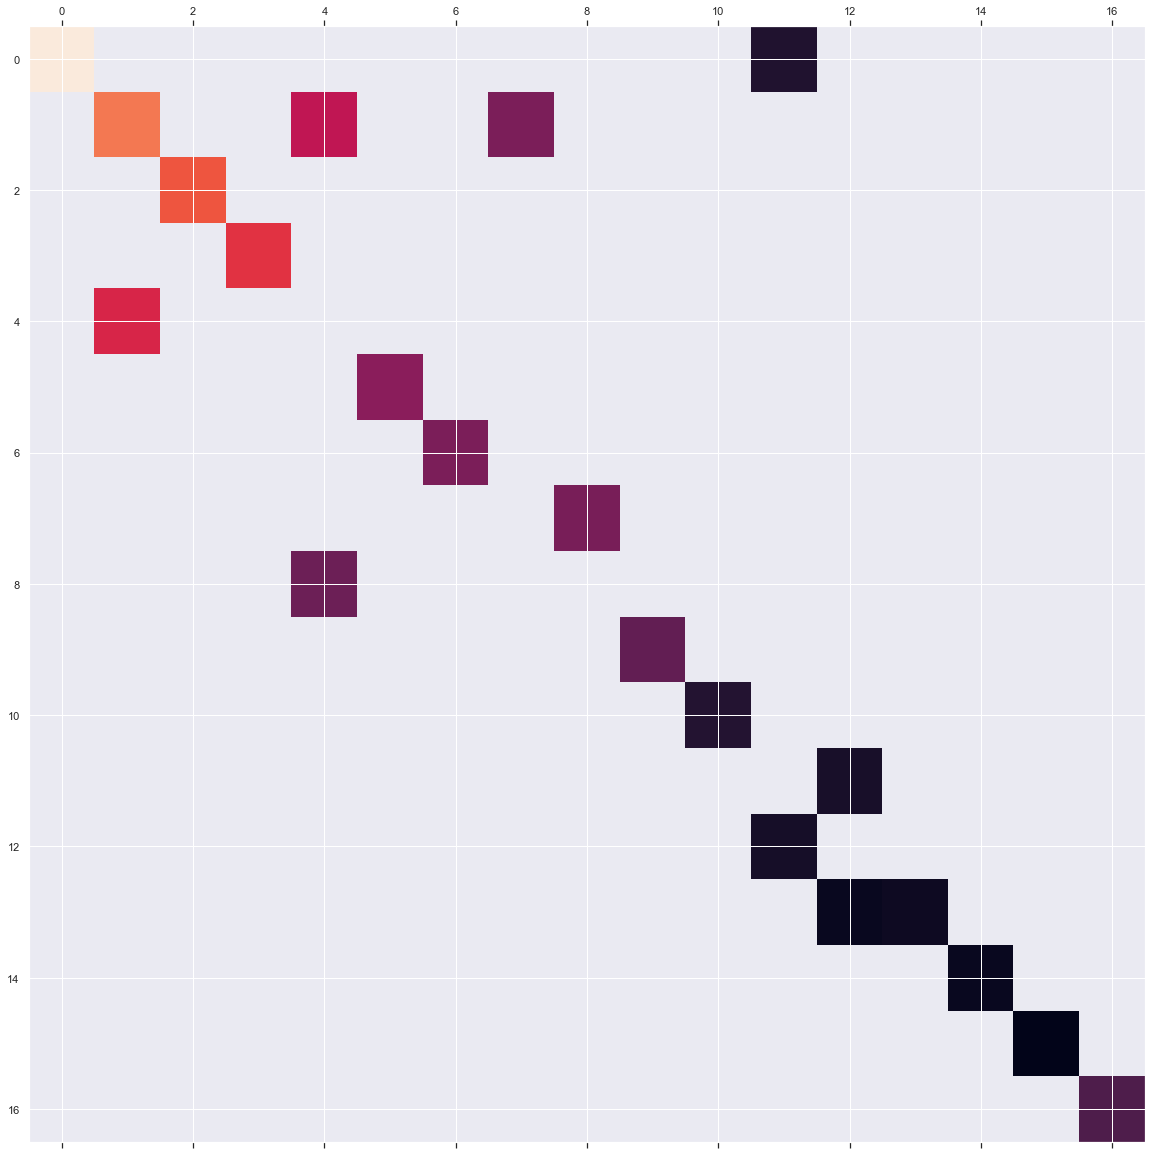

In [215]:
plt.figure(figsize=(40,20))
z = grouped_df.corr().unstack().sort_values(ascending=False).drop_duplicates().abs()
z = z[z > 0.7].unstack()
plt.matshow(z, fignum=1)

## visulize array value columns

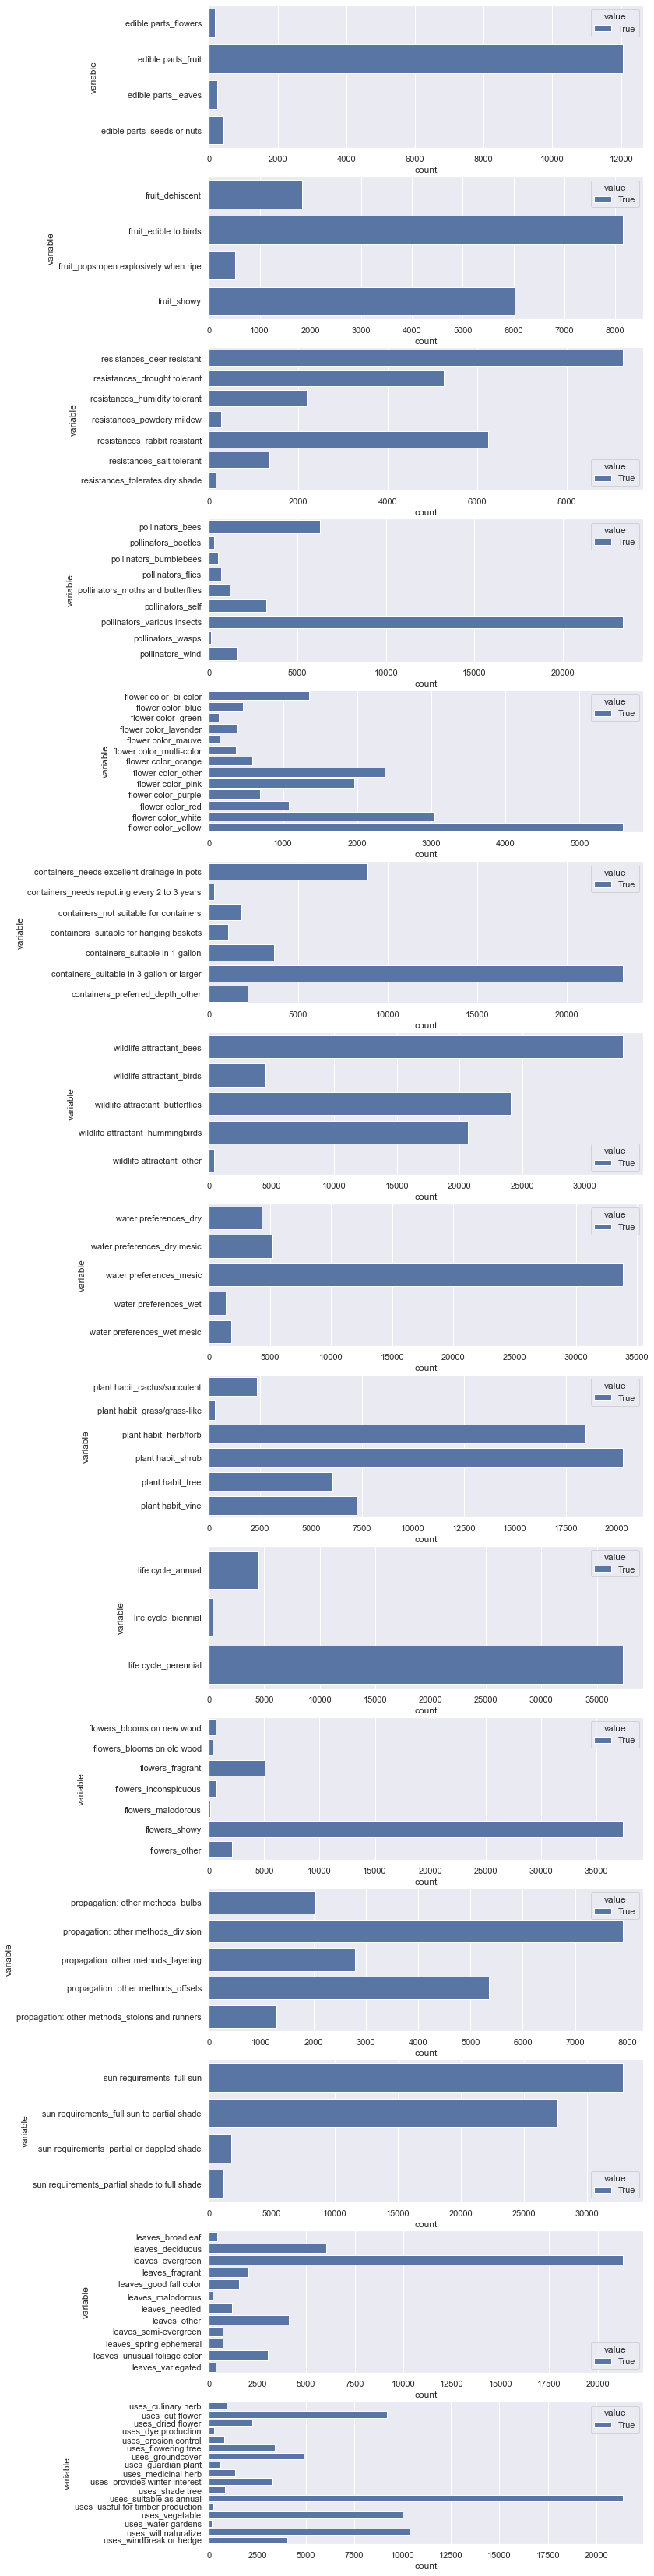

In [204]:
cols_prefix = ['edible parts', 'fruit', 'resistances', 'pollinators', 'flower color', 'containers', 'wildlife attractant', 'water preferences', 'plant habit', 'life cycle', 'flowers', 'propagation: other methods', 'sun requirements', 'leaves', 'uses']
fig, ax =plt.subplots(len(cols_prefix),figsize=(10,60))

for idx, col_prefix in enumerate(cols_prefix):
    df3 = grouped_df[[col for col in grouped_df if col.startswith(col_prefix)]]
    sns.countplot(y="variable", hue="value", data=pd.melt(df3)[pd.melt(df3).value], ax=ax[idx])
    

## visualize numeric coluns

<AxesSubplot:xlabel='bloom size', ylabel='Count'>

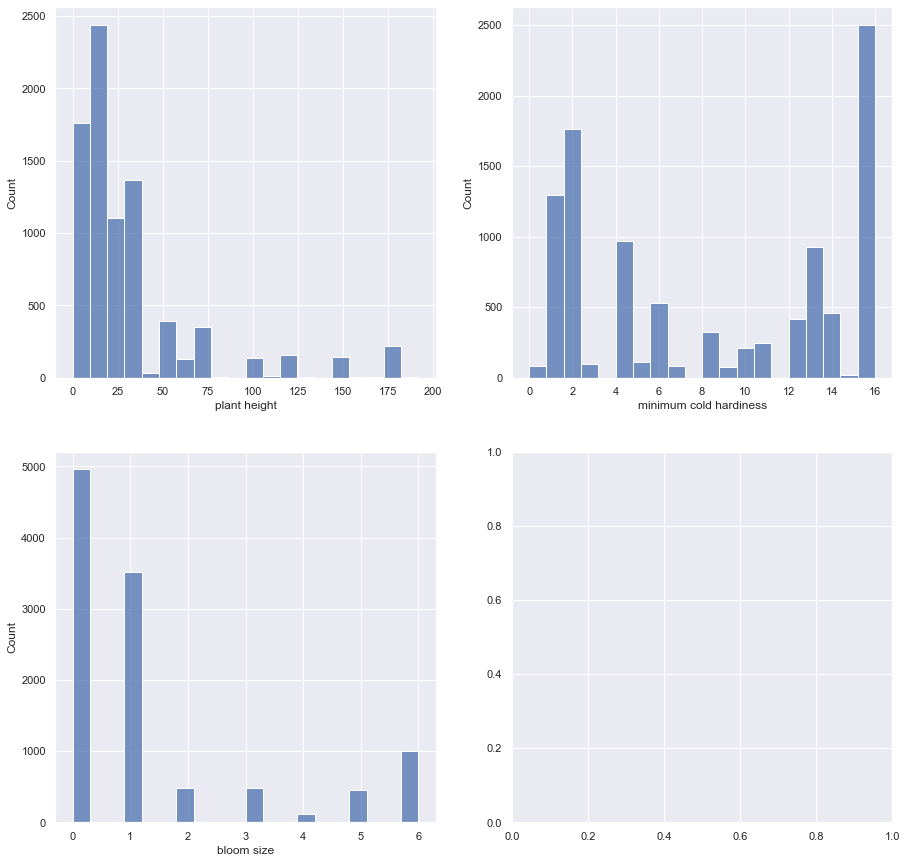

In [209]:
fig, ax =plt.subplots(2,2)

fig.set_figheight(15)
fig.set_figwidth(15)

sns.histplot(data=df_not_red_other[df_not_red_other['plant height'] < 200], x='plant height', bins=20, ax=ax[0][0])
sns.histplot(data=df_not_red_other[df_not_red_other['minimum cold hardiness'] < 200], x='minimum cold hardiness', bins=20, ax=ax[0][1])
sns.histplot(data=df_not_red_other[df_not_red_other['bloom size'] < 200], x='bloom size', bins=20, ax=ax[1][0])

## finding high correlated features to medicinal use

In [210]:
grouped_df.corr()[grouped_df.corr()['uses_medicinal herb'] > 0.2]['uses_medicinal herb']

plant height                         0.344682
leaves_fragrant                      0.450269
leaves_malodorous                    0.307539
uses_culinary herb                   0.362171
uses_dried flower                    0.212314
uses_medicinal herb                  1.000000
uses_useful for timber production    0.382195
edible parts_leaves                  0.229073
edible parts_seeds or nuts           0.217817
Name: uses_medicinal herb, dtype: float64

## save dataframe as pickle

In [214]:
with open('./final_df.pickle','wb') as file:
    pickle.dump(grouped_df, file)